>### Reference
- https://keras.io/examples/vision/edsr/
- Deep learning with Python 2nd
- 빵형 Youtube

>### imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import PIL
import PIL.Image
import cv2, os, glob
from skimage.transform import pyramid_expand
from skimage.transform import pyramid_reduce 

import tensorflow as tf
# import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

plt.style.use('dark_background')    

import warnings
warnings.filterwarnings(action='ignore')

def fn_makedirs(path): 
   try: 
        os.makedirs(path) 
   except OSError: 
       if not os.path.isdir(path): 
           raise

>### 데이터 전처리(preprocessing)
- 1) 데이터는 네트워크에 주입되기 전에 부동 소수점 타입의 텐서로 적절하게 전처리
- 2) 사진 피일을 읽는다.
- 3) JPEG 콘텐츠를 RGB 픽셀 값으로 디코딩합니다.
- 4) 그 다음, 부동 소수점 타입의 텐서로 변환
- 5) 동일한 크기의 이미지로 변경
- 6) 배치로 묶는다.

>### Download / load the training dataset

In [5]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)

data_dir = pathlib.Path(data_dir)

In [6]:
print('data_dir:', data_dir, type(data_dir))

data_dir: C:\Users\sel04327\.keras\datasets\flower_photos <class 'pathlib.WindowsPath'>


>### directory 구조
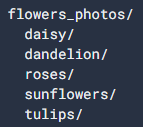

>### data의 갯수 확인

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_list = list(data_dir.glob('*/*.jpg'))
print(image_count)
print(image_list[:3])

3670
[WindowsPath('C:/Users/sel04327/.keras/datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg'), WindowsPath('C:/Users/sel04327/.keras/datasets/flower_photos/daisy/10140303196_b88d3d6cec.jpg'), WindowsPath('C:/Users/sel04327/.keras/datasets/flower_photos/daisy/10172379554_b296050f82_n.jpg')]


>### 데이터 출력

C:\Users\sel04327\.keras\datasets\flower_photos\roses\10090824183_d02c613f10_m.jpg
roses count: 641


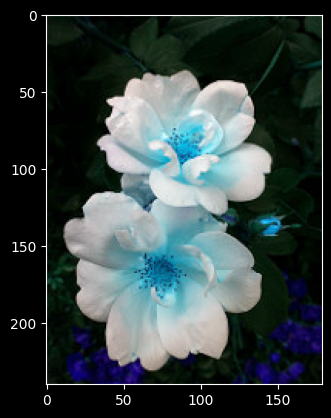

In [8]:
roses = sorted(list(data_dir.glob('roses/*')))
print(roses[0])

roses_cnt = len(roses)
print('roses count:', roses_cnt)

img_sample = cv2.imread(os.path.join(roses[0]))
plt.imshow(img_sample)

In [9]:
print('sample의 형태: ', img_sample.shape)

shape_list = []
for idx, image in enumerate(image_list):
    _ = cv2.imread(os.path.join(image))
    shape_list.append(_.shape)

print('image_list 중, 최소사이즈:', min(shape_list))

cnt = 0
idx_list = []
for idx, item in enumerate(shape_list):
    if item < (200, 200):
        cnt += 1
        idx_list.append(idx)
        
print(cnt)
print(idx_list)

sample의 형태:  (240, 179, 3)
image_list 중, 최소사이즈: (159, 240, 3)
16
[276, 420, 444, 597, 2297, 2498, 2522, 2886, 2959, 3020, 3121, 3193, 3310, 3324, 3332, 3494]


>### Sample 데이터 check
- Crop / DownScale 통해, Low / High resolution(input/target) 만들기

240 179
0 1


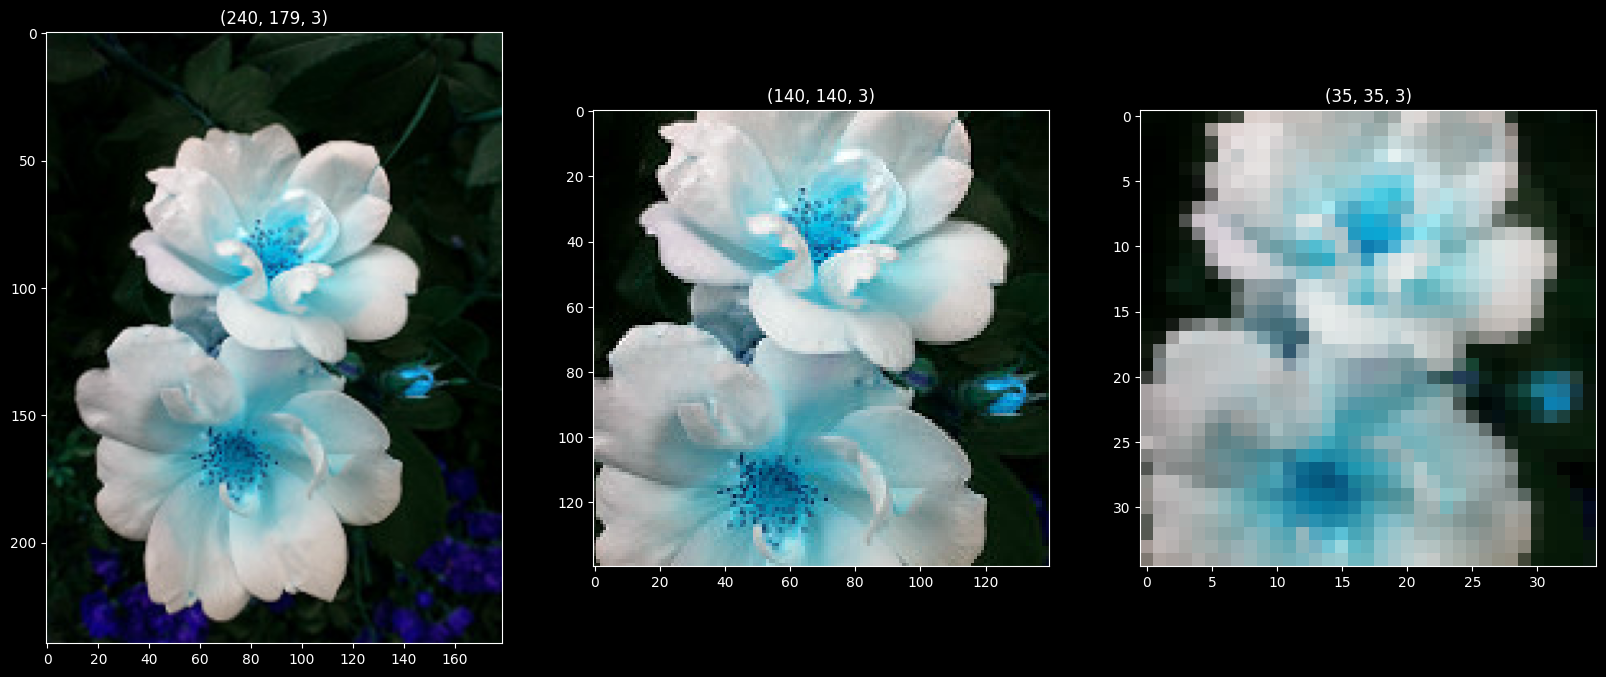

In [10]:
import matplotlib.pyplot as plt

h, w, _ = img_sample.shape
print(h, w)

## 홀수일 경우, 정확히 정사각형 image shape이 같아지지 않는 경우를 prevent
odd_h = 0
odd_w = 0
if h % 2 == 1:
    odd_h = 1
if w % 2 == 1:
    odd_w = 1

wnt_size = 140

print(odd_h, odd_w)

plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
plt.title(img_sample.shape)
plt.imshow(img_sample)

## 정사각형으로 이미지 자르기
crop_sample = img_sample[round((h-wnt_size)/2)+odd_h:round(-(h-wnt_size)/2), round((w-wnt_size)/2)-odd_w:round(-(w-wnt_size)/2), :]
plt.subplot(1, 3, 2)
plt.title(crop_sample.shape)
plt.imshow(crop_sample)

## 정사각형 이미지를 pyramid_reduce를 통해서 downscale한다.
from skimage.transform import pyramid_reduce
down_sample = pyramid_reduce(crop_sample, downscale=4, multichannel=True)
plt.subplot(1, 3, 3)
plt.title(down_sample.shape)
plt.imshow(down_sample)

>### Input: LowRes data
>### output: HighRes data 생성하기

In [11]:
print(data_dir)
fn_makedirs(os.path.join(data_dir, 'dataset'))

fn_makedirs(os.path.join(data_dir, 'dataset' ,'lowres'))
fn_makedirs(os.path.join(data_dir, 'dataset', 'highres'))

img_path = list(data_dir.glob('*/*.jpg'))

file_list = []
for i in range(image_count):
    file_list.append(os.path.join(img_path[i]))

C:\Users\sel04327\.keras\datasets\flower_photos


In [12]:
print(file_list[:3])

['C:\\Users\\sel04327\\.keras\\datasets\\flower_photos\\daisy\\100080576_f52e8ee070_n.jpg', 'C:\\Users\\sel04327\\.keras\\datasets\\flower_photos\\daisy\\10140303196_b88d3d6cec.jpg', 'C:\\Users\\sel04327\\.keras\\datasets\\flower_photos\\daisy\\10172379554_b296050f82_n.jpg']


In [13]:
input_dir = os.path.join(data_dir, 'dataset' ,'lowres')
target_dir = os.path.join(data_dir, 'dataset', 'highres')

print(input_dir)
print(target_dir)

C:\Users\sel04327\.keras\datasets\flower_photos\dataset\lowres
C:\Users\sel04327\.keras\datasets\flower_photos\dataset\highres


>### Preprocessing 데이터 전처리

In [14]:
def create_lr_hr_image(img_path):
    # Read image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize image to fixed size
    img = tf.image.resize(img, [200, 200], method=tf.image.ResizeMethod.BICUBIC)

    # Normalize the high-resolution image
    hr_img = tf.cast(img, tf.float32) / 255.0

    # Downscale and normalize the low-resolution image
    lr_img = tf.image.resize(img, [50, 50], method=tf.image.ResizeMethod.BICUBIC)
    lr_img = tf.cast(lr_img, tf.float32) / 255.0

    return lr_img, hr_img


def create_dataset(file_list, batch_size=16, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(file_list)

    # Load and preprocess images in parallel
    def load_and_preprocess(file_path):
        lr_image, hr_image = tf.py_function(create_lr_hr_image, [file_path], [tf.float32, tf.float32])
        return lr_image, hr_image

    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    # Filter out None values
    dataset = dataset.filter(lambda x, y: x is not None and y is not None)

    # Shuffle and repeat the dataset, then batch the data
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [15]:
dataset = create_dataset(file_list=file_list, batch_size=16, shuffle=True)

# Preview a batch of data
for lr_images, hr_images in dataset.take(1):
    print('Low-resolution images shape:', lr_images.shape)
    print('High-resolution images shape:', hr_images.shape)

Low-resolution images shape: (16, 50, 50, 3)
High-resolution images shape: (16, 200, 200, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


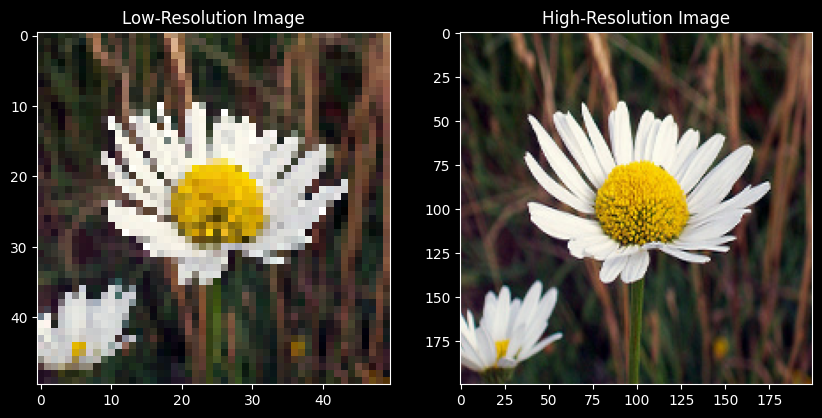

In [26]:
# Take the first 16 images from the dataset and visualize them
for i, (lr_image, hr_image) in enumerate(dataset.take(1)):
    # Convert the low-resolution and high-resolution images to NumPy arrays
    lr_image_np = lr_image.numpy()[0]
    hr_image_np = hr_image.numpy()[0]

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

    # Display the low-resolution image
    ax1.imshow(lr_image_np)
    ax1.set_title('Low-Resolution Image')

    # Display the high-resolution image
    ax2.imshow(hr_image_np)
    ax2.set_title('High-Resolution Image')

    # Show the figure
    plt.show()

>### GPU를 사용하여 데이터셋을 불러오는 함수일 경우

In [17]:
# GPU를 사용 가능한지 체크
if tf.config.list_physical_devices('GPU'):
    # GPU를 사용하여 데이터셋을 불러오는 함수 정의
    def create_dataset(file_list, batch_size=16, shuffle=True):
        # 데이터셋 생성
        dataset = tf.data.Dataset.from_tensor_slices(file_list)

        # Load and preprocess images in parallel
        def load_and_preprocess(file_path):
            lr_image, hr_image = tf.py_function(create_lr_hr_image, [file_path], [tf.float32, tf.float32])
            return lr_image, hr_image

        dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

        # Filter out None values
        dataset = dataset.filter(lambda x, y: x is not None and y is not None)

        # Shuffle and repeat the dataset, then batch the data
        if shuffle:
            dataset = dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
        dataset = dataset.repeat()
        dataset = dataset.batch(batch_size, drop_remainder=True)

        # 데이터셋의 batch들이 GPU에서 처리되도록 설정
        dataset = dataset.apply(tf.data.experimental.prefetch_to_device("/device:GPU:0", buffer_size=tf.data.AUTOTUNE))

        return dataset
else:
    # GPU를 사용할 수 없다면 이전의 코드와 동일하게 진행
    def create_dataset(file_list, batch_size=16, shuffle=True):
        dataset = tf.data.Dataset.from_tensor_slices(file_list)

        # Load and preprocess images in parallel
        def load_and_preprocess(file_path):
            lr_image, hr_image = tf.py_function(create_lr_hr_image, [file_path], [tf.float32, tf.float32])
            return lr_image, hr_image

        dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

        # Filter out None values
        dataset = dataset.filter(lambda x, y: x is not None and y is not None)

        # Shuffle and repeat the dataset, then batch the data
        if shuffle:
            dataset = dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
        dataset = dataset.repeat()
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

        return dataset

In [31]:
# GPU가 사용 가능한지 확인
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

# GPU 메모리 증분 모드 설정
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

Num GPUs: 1


In [32]:
import time

# GPU를 사용하여 데이터셋을 생성하는 경우
start_time = time.time()
with tf.device('/GPU:0'):
    dataset = create_dataset(file_list=file_list, batch_size=100, shuffle=True)
end_time = time.time()
print('GPU elapsed time:', end_time - start_time)

# CPU를 사용하여 데이터셋을 생성하는 경우
start_time = time.time()
dataset = create_dataset(file_list=file_list, batch_size=100, shuffle=True)
end_time = time.time()
print('CPU elapsed time:', end_time - start_time)

GPU elapsed time: 0.10394406318664551
CPU elapsed time: 0.10390520095825195


In [33]:
import tensorflow as tf
import time

# GPU 환경에서 TensorFlow 실행을 위해 필요한 코드입니다.
# 만약, CPU를 사용한다면 아래 코드는 필요 없습니다.
tf.debugging.set_log_device_placement(True)

# GPU를 사용하도록 설정합니다.
# 만약, CPU를 사용한다면 "/CPU:0"로 설정합니다.
with tf.device("/GPU:0"):
    # 데이터 생성 및 전처리
    x = tf.random.normal([10000, 1000])
    y = tf.random.normal([1000, 2000])
    
    # CPU와 GPU의 처리 시간 비교
    start_time = time.time()
    z_cpu = tf.matmul(x, y)
    print("CPU time:", time.time() - start_time)
    
    start_time = time.time()
    z_gpu = tf.matmul(x, y)
    print("GPU time:", time.time() - start_time)

CPU time: 1.415881633758545
GPU time: 0.004987001419067383


In [17]:
# 파일 이름 가져오기
input_filenames = tf.constant([os.path.join(input_dir, fname) for fname in os.listdir(input_dir)])
target_filenames = tf.constant([os.path.join(target_dir, fname) for fname in os.listdir(target_dir)])

# 데이터셋 생성
dataset = tf.data.Dataset.from_tensor_slices((input_filenames, target_filenames))

>### 전체 데이터셋 크기를 구함
- train set 크기 정함
- from_tensor_slices() 메서드는 your_data를 tf.data.Dataset으로 변환합니다. 
    - take() 메서드는 데이터셋의 앞부분을 추출하여 train set으로 만들고, 
    - skip() 메서드는 추출한 부분을 제외한 나머지를 test set으로 만듭니다.

In [18]:
dataset_size = len(input_filenames)
print(dataset_size)

train_size = int(0.8 * dataset_size)

# train set과 test set으로 데이터셋을 분할합니다.
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

print(len(train_dataset), len(test_dataset))

3272
2617 655


In [20]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [19]:
type(train_dataset)
print(train_dataset.take(1))

<TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>


In [ ]:
input_dataset = input_dataset.map(lambda x: np.load(x.numpy().decode('utf-8')))

In [21]:
def load_image(input_filenames, target_filenames):
    input_image = tf.io.read_file(input_filenames)
    input_image = tf.image.decode_png(input_image, channels=3)
    target_image = tf.io.read_file(target_filenames)
    target_image = tf.image.decode_png(target_image, channels=3)
    return input_image, target_image


dataset = train_dataset.map(load_image)

In [25]:
print(dataset)

<MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None))>


In [27]:
dataset = dataset.map(lambda x: np.load(x.numpy()))
dataset = dataset.batch(1)

# 이미지 출력
for data in dataset:
    # input_image 출력
    plt.imshow(data[0])
    plt.show()  

TypeError: in user code:


    TypeError: <lambda>() takes 1 positional argument but 2 were given


>### Flip & crop: argument

In [1]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

NameError: name 'keras' is not defined